# Ensemble Analysis for New Hampshire

In [1]:
%matplotlib inline

from functools import partial
import json
import random

import matplotlib.pyplot as plt
import networkx as nx
from gerrychain import Partition, Graph, MarkovChain, updaters, constraints, accept
from gerrychain.proposals import recom
from gerrychain.tree import recursive_tree_part, bipartition_tree
from gerrychain.random import random
import pandas as pd

from rba import constants
from rba.district_quantification import quantify_gerrymandering
from rba.util import get_num_vra_districts
from rba.visualization import visualize_partition_geopandas

In [2]:
# CONSTANTS

random.seed(2023)
GEODATA_FILE = "../rba/data/2010/new_hampshire_geodata_merged.json"
COMMUNITY_OUTPUT_FILE = "../rba/data/2010/new_hampshire_communities.json"
VRA_CONFIG_FILE = "../rba/data/2010/vra_nh.json"
NUM_DISTRICTS = 2

In [3]:
# LOADING DATA

with open(GEODATA_FILE, "r") as f:
    data = json.load(f)
nx_graph = nx.readwrite.json_graph.adjacency_graph(data)
graph = Graph.from_networkx(nx_graph)
del nx_graph

with open(COMMUNITY_OUTPUT_FILE, "r") as f:
    community_data = json.load(f)

edge_lifetimes = {}
for edge, lifetime in community_data["edge_lifetimes"].items():
    u = edge.split(",")[0][2:-1]
    v = edge.split(",")[1][2:-2]
    edge_lifetimes[(u, v)] = lifetime

with open(VRA_CONFIG_FILE, "r") as f:
    vra_config = json.load(f)

vra_threshold = vra_config["opportunity_threshold"]
del vra_config["opportunity_threshold"]


In [4]:
# UPDATERS

rba_updaters = {
    "population": updaters.Tally("total_pop", alias="population"),
    "gerry_scores": lambda partition: quantify_gerrymandering(
        partition.graph,
        {dist: subgraph for dist, subgraph in partition.subgraphs.items()},
        edge_lifetimes
    )
}

vra_updaters = {f"num_{minority}_vra_districts": partial(get_num_vra_districts,
                                                         label=f"total_{minority}",
                                                         threshold=vra_threshold)
                for minority in vra_config.keys()}

rba_updaters.update(vra_updaters)

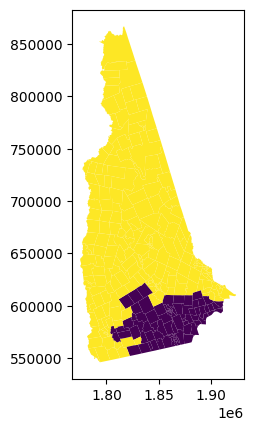

In [5]:
# INITIAL STATE

state_population = 0
for node in graph:
    state_population += graph.nodes[node]["total_pop"]
ideal_population = state_population / NUM_DISTRICTS

initial_assignment = recursive_tree_part(
    graph, range(NUM_DISTRICTS),
    pop_target=ideal_population,
    pop_col="total_pop",
    epsilon=constants.POP_EQUALITY_THRESHOLD)

initial_partition = Partition(graph, initial_assignment, rba_updaters)

visualize_partition_geopandas(initial_partition)

In [6]:
# PROPOSAL METHOD

# weighted_recom_proposal = partial(
#     recom,
#     pop_col="total_pop",
#     pop_target=ideal_population,
#     epsilon=constants.POP_EQUALITY_THRESHOLD,
#     node_repeats=2,
#     method=partial(
#         bipartition_tree,
#         spanning_tree_fn=get_county_weighted_random_spanning_tree)
# )

recom_proposal = partial(recom,
    pop_col="total_pop",
    pop_target=ideal_population,
    epsilon=constants.POP_EQUALITY_THRESHOLD,
    node_repeats=2
)

# CONSTRAINTS

# NOTE: we said we wouldn't have a compactness constraint but GerryChain uses one in their example
# showing that maybe it's necessary even for ReCom. This keeps the proposals within 2x the number of
# cut edges in the starting one.
# compactness_bound = constraints.UpperBound(
#     lambda p: len(p["cut_edges"]),
#     2 * len(initial_partition["cut_edges"])
# )

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition,
                                                                constants.POP_EQUALITY_THRESHOLD)

vra_constraints = [
    constraints.LowerBound(
        lambda p: p[f"num_{minority}_vra_districts"],
        num_districts
    )
    for minority, num_districts in vra_config.items()]

In [7]:
chain = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        pop_constraint,
        # compactness_bound
    ] + vra_constraints,
    # accept=lambda p: random.random() < get_county_border_proportion(p),
    accept=accept.alaways_accept,
    initial_state=initial_partition,
    total_steps=1000
)

In [8]:
df = pd.DataFrame(columns=[f"district{i}" for i in range(1, NUM_DISTRICTS + 1)] + ["state_gerry_score"], dtype=float)

saved_partitions = []
for i, partition in enumerate(chain.with_progress_bar()):
    district_scores, state_score = partition["gerry_scores"]
    df.loc[len(df.index)] = sorted(list(district_scores.values())) + [state_score]
    if i % 100 == 0:
        saved_partitions.append(partition)

  0%|          | 0/1000 [00:00<?, ?it/s]

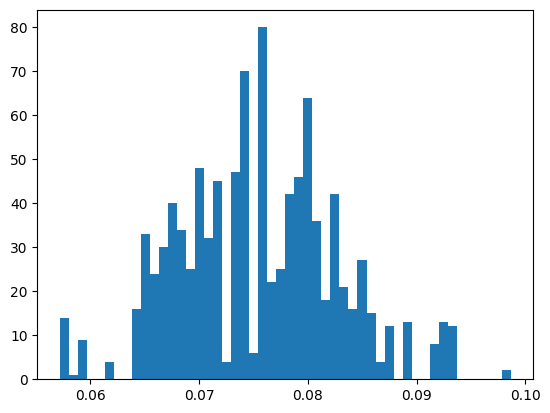

In [9]:
plt.hist(df["state_gerry_score"], bins=50)
plt.show()

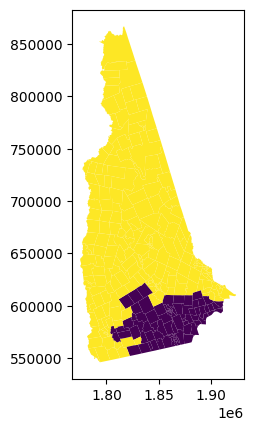

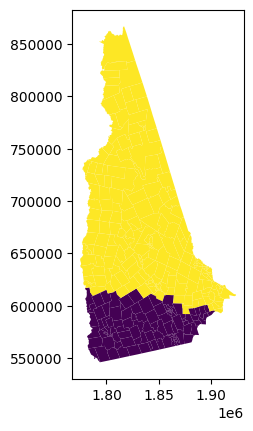

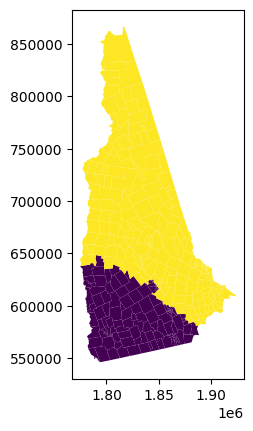

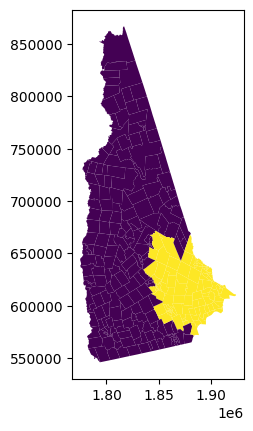

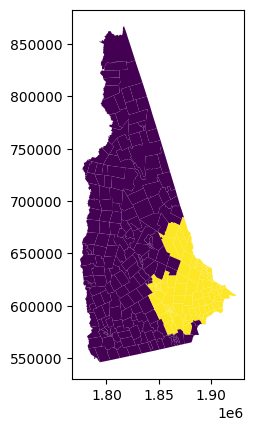

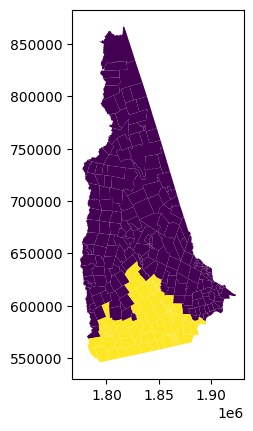

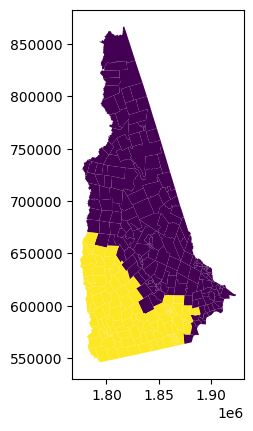

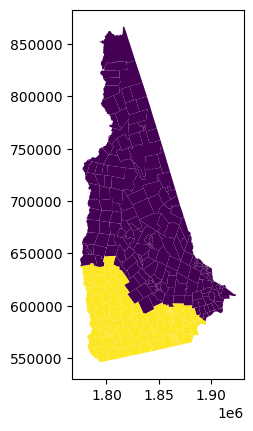

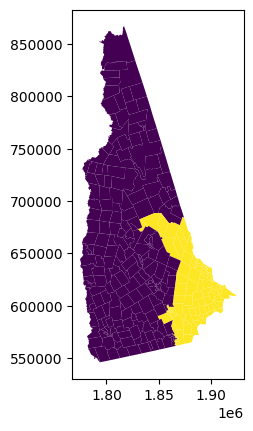

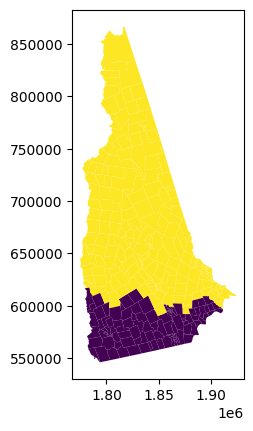

In [10]:
for i, partition in enumerate(saved_partitions):
    visualize_partition_geopandas(partition)  # TODO: add titles for what index in the chain each image is from.

In [11]:
print(df)

     district1  district2  state_gerry_score
0     0.081633   0.081633           0.081633
1     0.081633   0.081633           0.081633
2     0.081633   0.081633           0.081633
3     0.081633   0.081633           0.081633
4     0.081633   0.081633           0.081633
..         ...        ...                ...
995   0.080000   0.080000           0.080000
996   0.080000   0.080000           0.080000
997   0.080000   0.080000           0.080000
998   0.080000   0.080000           0.080000
999   0.080000   0.080000           0.080000

[1000 rows x 3 columns]
